In [34]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im

#Otsu Thresholding

#Get Bin Centers
def bin_center(edges):
    edges1 = edges[:-1]
    edges2 = edges[1:]
    mids = (edges1 + edges2) / 2
    
    return mids
    
#Get probabilities w1, w2 after iterating thresholds    
def get_weights(histogram):
    w1 = np.cumsum(histogram)
    
    w2 = np.cumsum(histogram[::-1])
    
    return w1, w2[::-1]

def get_variance(histogram, bin_centers, weight1, weight2):
    # Calculating means
    temp1 = np.cumsum(histogram * bin_centers) 
    mean1 = temp1 / weight1
    
    hist_bin_centers = (histogram * bin_centers)
    temp2 = (np.cumsum(hist_bin_centers[::-1]) / weight2[::-1])
    mean2 = temp2[::-1]

    weights_prod = weight1[:-1] * weight2[1:] 
    mean_prod = mean1[:-1] - mean2[1:]
    variance = weights_prod * mean_prod ** 2
    
    return variance
    

def otsu_thresholding(image, binscount):

    histogram, binEdges = np.histogram(image, bins=binscount)
    
    bin_centers = bin_center(binEdges)
    
    weight1, weight2 = get_weights(histogram)

    inter_class_variance = get_variance(histogram, bin_centers, weight1, weight2)

    max_variance_val = np.argmax(inter_class_variance)

    otsu_threshold = bin_centers[:-1][max_variance_val]
    
    return otsu_threshold

image = cv.imread('Satellite.png', 0) 
image_copy = cv.imread('Satellite.png', 0)
threshold = otsu_thresholding(image, 256)
print("Otsu's algorithm implementation thresholding result: ", round(threshold, 2))

for a in range(image.shape[0]):
    for b in range(image.shape[1]):
        image_copy[a,b] = 255 if image_copy[a,b] > threshold else 0

final_image = im.fromarray(image_copy)
final_image
final_image.save("Satellite-Otsu.png")

Otsu's algorithm implementation thresholding result:  126.01


In [7]:
### ISODATA

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im

def get_bg_fg_mean(image, meanbg, meanfg, pixelsbg, pixelsfg, threshold):
    
    shape1 = image.shape[0]
    shape2 = image.shape[1]
    
    for i in range(shape1):
        for j in range(shape2):
            pixval = image[i, j]
            
            pixelsfg = pixelsfg + 1 if pixval > threshold else pixelsfg
            meanfg = meanfg + pixval if pixval > threshold else meanfg
            
            pixelsbg = pixelsbg + 1 if pixval < threshold else pixelsbg
            meanbg = meanbg + pixval if pixval < threshold else meanbg
    
    if pixelsbg > 0:
        final_bg_mean = meanbg/pixelsbg 
        final_fg_mean = meanfg/pixelsfg
    else:
        final_bg_mean = meanbg
        final_fg_mean = meanfg
        
    return final_bg_mean, final_fg_mean
    
    
def isodata_thresholding(image, val):
    threshold = val

    while True:        
        bg_mean, fg_mean = get_bg_fg_mean(image, 0, 0, 0, 0, threshold)

        avg_threshold = (bg_mean + fg_mean)/2
        if threshold != int(avg_threshold):
            return avg_threshold
        else:
            break
    
image = cv.imread('Algae.png', 0) 
image_copy = cv.imread('Algae.png', 0)
threshold = isodata_thresholding(image, 100)
print("Isodata algorithm implementation thresholding result: ", round(threshold, 2))

for a in range(image.shape[0]):
    for b in range(image.shape[1]):
        image_copy[a,b] = 255 if image_copy[a,b] > threshold else 0

final_image = im.fromarray(image_copy)
final_image
final_image.save("Algae-Isodata.png")

Isodata algorithm implementation thresholding result:  108.08


Triangle algorithm implementation thresholding result:  250


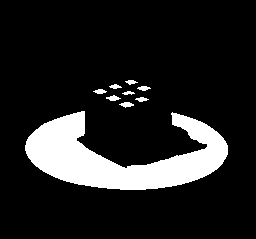

In [6]:
###TRIANGLE

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im
import math

def count_mini(image, shape1, shape2):
    count = [0]*256
    min1 = -150
    min2 = -150
    
    for i in range(shape1):
        for j in range(shape2):
            pixval = image[i, j]
            count[pixval] = count[pixval] + 1

    i = 0
    while i != 256:
        if count[i]>0:
            min1 = i
            break
        i = i+1

    j = 255
    while j != -1:
        if count[j]>0:
            min2 = j
            break
        j = j-1
                    
    return min1, min2, count

def compute_mini_count(min1, min2, count):
    if min2<255:
        min2 = min2+1
    
    if min1>0:
        min1 = min1-1

    maximum = count.index(max(count))
    
    return min1, min2, maximum

def compute_lrhs(min1, min2, maximum):
    val1 = maximum - min1
    val2 = maximum - min2
    
    return val1, val2

def compute_vals(inversion, min1, min2, maximum, count, left, right):
    
    rightval = -1 * right
    
    if left > rightval:
        pass
    else:
        inversion = True
        le = 0 
        ri = 255
        min1, maximum = 255 - min2, 255 - maximum
        while ri > le:
            count[le] = count[ri]
            count[ri] = count[le]
            le, ri = le + 1, ri - 1
            
    return inversion, min1, maximum

def triangle_threshold(image, shape1, shape2):
    threshold = 0 
    ans = -1000
    inversion = False
 
    min1, min2, count = count_mini(image, image.shape[0], image.shape[1])
        
    min1, min2, maximum = compute_mini_count(min1, min2, count)
    
    left, right = compute_lrhs(min1, min2, maximum)

    inversion, min1, maximum = compute_vals(inversion, min1, min2, maximum, count, left, right)
        
    temp1 = count[maximum] * min1
    temp2 = (maximum-min1) * count[min1]

    for i in range(min1+1, maximum+1):
        t1 = count[maximum] * i
        t2 = (maximum-min1) * count[i]
        dist = t1 - t2 - (temp1 - temp2)
        if dist > ans:
            ans, threshold = dist, i
            
    if inversion != True:
        return threshold - 1
    else:
        tempt = 255 - threshold
        return tempt + 1
                
image = cv.imread("Rubik.png", cv.COLOR_BGR2GRAY)
image_copy = cv.imread('Rubik.png', 0)

shape1 = image.shape[0]
shape2 = image.shape[1]

threshold = triangle_threshold(image, shape1, shape2)

print("Triangle algorithm implementation thresholding result: ", round(threshold, 2))

for a in range(image.shape[0]):
    for b in range(image.shape[1]):
        image_copy[a,b] = 255 if image_copy[a,b] > threshold else 0

final_image = im.fromarray(image_copy)
final_image